## MFW Chapter 4: Distribution Fits 

This notebook will be divided into the following subsections:

1. Modelling the raw claim severities 
2. Modelling the raw claim counts with discrete distributions 
3. Modelling the detrended claim severities
4. Modelling the detrended claim counts 
5. Summary of best fit distributions

In [1]:
import numpy as np
import itertools
import random
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as ss
import scipy.integrate as integrate
import scipy.special as special

#changing the plot configuration:
plt.rcParams['figure.figsize'] = (5, 5)
plt.style.use('seaborn')

### Part 1. Modelling the raw claim severities 

In [2]:
#loading the database for the raw aggregated claims:
df = pd.read_csv("C:/Users/r_jun/Documents/ISEG MSc Actuarial Science/Thesis/Python/FINAL/CH4/Raw by Type/aggregated_series.csv")
df.describe()

,pdx,pds,plx,pls,cbx,cbs,cpx,cps
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,229.743590,43393.384423,255.448718,45801.327436,388.096154,59298.647628,120.897436,37450.703013
std,182.140955,23012.955179,208.589651,41028.606035,377.259229,59463.309234,56.016954,18528.229545
min,15.000000,4465.960000,14.000000,2033.880000,14.000000,1964.960000,14.000000,4121.360000
25%,127.750000,30391.940000,112.750000,18697.077500,157.250000,23802.515000,87.750000,26471.802500
50%,150.000000,37980.400000,152.000000,26495.180000,196.000000,30811.005000,105.500000,34139.190000
75%,259.500000,53313.577500,377.000000,62260.750000,507.500000,77035.832500,150.000000,46662.660000
max,873.000000,133835.070000,1007.000000,196328.290000,1670.000000,261424.430000,337.000000,137850.990000


#### 1. Kolmogorov-Smirnov Loop for all severities 

This loop performs the KS test for different distributions and sorts the best fits according to the p-values from the test. 

In [24]:
import warnings
warnings.filterwarnings("ignore")


#Distributions 
list_of_dists = ['beta','burr','cauchy','chi','chi2','dgamma','dweibull','expon','exponnorm','exponweib','exponpow',
                 'frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','gamma','gengamma',
                 'gompertz','gumbel_r','gumbel_l','hypsecant','invgamma','invgauss','invweibull',
                 'johnsonsb','johnsonsu','laplace','logistic','loglaplace','lognorm',
                 'lomax','nct','norm','pareto','t','triang','truncexpon','truncnorm','tukeylambda',
                 'uniform','weibull_min','weibull_max']

dfs = df[['pds', 'pls', 'cbs', 'cps']]


# retrieving the names of each asset from the dataset:
names = list(dfs.columns)
# loop to find the best fit distribution according to Kolmogorov-Smirnov test:
bestfits = {}
for n in tqdm(names):
    results = []
    for i in list_of_dists:
        dist = getattr(ss, i)
        param = dist.fit(dfs[n], floc=0)##### FIXING THE LOCATION PARAMETER AT ZERO
        a = ss.kstest(dfs[n], i, args=param)
        results.append((i,param, a[0],a[1]))
        dfr = pd.DataFrame(results, columns =['Best fit dist', 'MLE params', 'KS stat', 'p-value'])
        dfr.sort_values(by=['p-value'], ascending=False, inplace=True)
    bestfits[n] = dfr.iloc[0]
# storing the best fits in a dataframe:    
BF1 = pd.DataFrame.from_dict(bestfits)
BF1

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.18s/it]


,pds,pls,cbs,cps
Best fit dist,loglaplace,lognorm,lognorm,loglaplace
MLE params,"(2.481704232311386, 0, 37891.93289315458)","(0.9086819314521254, 0.0, 31402.11730335455)","(0.9336879708982427, 0.0, 38838.349755978605)","(2.470615641302211, 0, 34138.78552976878)"
KS stat,0.076378,0.0892836,0.107154,0.0480359
p-value,0.306897,0.156464,0.0515625,0.847086


#### 2. $\chi^2$ Loop for property damage severity 

The loop below is a sample of how the $\chi^2$ can be performed for one variable. Note that the location parameter is set at zero and the lowest bound starts at 0, while the highest bound is set at 600,000. 

In [49]:
#PDS
qs = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1]

#Distributions 
list_of_dists = ['beta','burr','chi','chi2','expon','exponweib','exponpow',
                 'frechet_r','genlogistic','genpareto','genexpon','gamma',
                 'gompertz','invgamma','invgauss','invweibull', 'johnsonsb','johnsonsu','loglaplace','lognorm',
                 'lomax','nct','triang','truncexpon','truncnorm', 'uniform','weibull_min']

X1 = df['pds'].to_numpy()

results = []
for i in tqdm(list_of_dists):
    dist = getattr(ss, i)
    param = list(dist.fit(X1, floc=0))
    pq1 = list(dist.ppf(qs, *param))
    pq1.insert(0,0)
    pq1 = list(pq1[:-1])
    pq1.append(600000)
    hist, bin_edges = np.histogram(X1, bins=pq1)
    n = len(X1)
    freq1 = list(hist)
    B = list(bin_edges)
    fexp1 = []
    for k in range(1,21):
        f = ((dist.cdf(B[k], *param) - dist.cdf(B[k-1], *param))*n)
        fexp1.append(f)
    a = ss.chisquare(f_obs=freq1, f_exp=fexp1, ddof=len(param))
    results.append((i,param, a[0],a[1]))
    
    
dfr = pd.DataFrame(results, columns =['Distribution', 'Parameters', 'Chi-square stat', 'P-value'])
dfr.sort_values(by=['P-value'], ascending=False, inplace=True)
dfr

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.84it/s]


,Distribution,Parameters,Chi-square stat,P-value
18,loglaplace,"[2.481704232311386, 0, 37891.93289315458]",23.728293,9.560913e-02
17,johnsonsu,"[-2.8807863215812253, 2.4426244219975963, 0, 2...",26.683646,3.142212e-02
8,genlogistic,"[8.7133357102544, 0, 16070.20471407431]",34.660732,4.421428e-03
19,lognorm,"[0.5854282465240674, 0.0, 37495.35836664275]",36.820443,2.222576e-03
5,exponweib,"[2.273487222871073, 1.3583290570719742, 0, 320...",36.820513,1.344168e-03
3,chi2,"[7.161317521911302, 0, 6059.4135809080435]",40.410256,6.780747e-04
11,gamma,"[3.5806589043996295, 0, 12118.826613101453]",40.410256,6.780747e-04
0,beta,"[3.5804930205233103, 509828.5840461837, 0, 617...",40.410256,3.931129e-04
16,johnsonsb,"[1.9416773559852272, 1.3635342825060341, 0, 20...",45.282051,6.910622e-05
26,weibull_min,"[1.9857732104402275, 0, 49000.59779225627]",48.358974,4.171001e-05


In [50]:
dfr.iloc[1,1]

[-2.8807863215812253, 2.4426244219975963, 0, 27045.30268362849]

Looking at the results, only the Loglaplace and Johnson SU were good fits, as they pass the $\chi^2$ at a 99% significance level. For this example, we will plot these two distributions along with the Genlogistic and Lognormal fits:

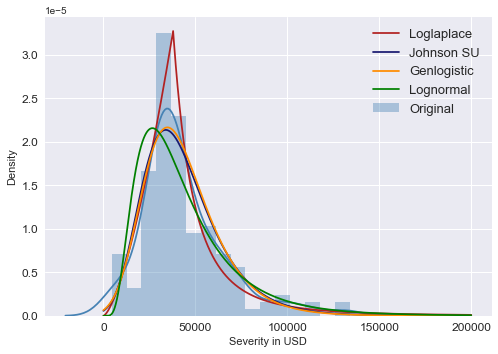

In [7]:
x = np.linspace(0, 200000, 5000)

#making the pdf for this linespace:
data_loglaplace = ss.loglaplace.pdf(x, *dfr.iloc[0,1])
data_johnson = ss.johnsonsu.pdf(x, *dfr.iloc[1,1])
data_genlogistic = ss.genlogistic.pdf(x, *dfr.iloc[2,1])
data_lognormal = ss.lognorm.pdf(x, *dfr.iloc[3,1])

#comparison
sns.distplot(X1, hist=True, kde=True, label="Original", color="steelblue")
plt.plot(x, data_loglaplace, label="Loglaplace", color="firebrick")
plt.plot(x, data_johnson, label="Johnson SU", color="midnightblue")
plt.plot(x, data_genlogistic, label="Genlogistic", color="darkorange")
plt.plot(x, data_lognormal, label="Lognormal", color="green")
plt.xlabel("Severity in USD")
plt.ylabel("Density")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=13)
plt.savefig('pds_comparison.png', dpi=300, bbox_inches='tight')

#### 3. $\chi^2$ Loop for all raw claim severity 

The code chunk below simply adds another dimension to the loop, in order to find the best fit distribution using the $\chi^2$ test for all the severity variables.

In [38]:
import warnings
warnings.filterwarnings("ignore")
#setting up the quantiles to build the bins:
qs = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1]

#Distributions 
list_of_dists = ['beta','burr','chi','chi2','expon','exponweib','exponpow',
                 'frechet_r','genpareto','genexpon','gamma',
                 'gompertz','invgamma','invgauss','invweibull', 'johnsonsb','johnsonsu','loglaplace','lognorm',
                 'lomax','triang','truncexpon','truncnorm', 'uniform','weibull_min']


dfs = df[['pds', 'pls', 'cbs', 'cps']]


# retrieving the names of each asset from the dataset:
names = list(dfs.columns)

bestfits = {}
for na in tqdm(names):
    results = []
    for i in list_of_dists:
        dist = getattr(ss, i)
        param = list(dist.fit(dfs[na], floc=0))
        pq1 = list(dist.ppf(qs, *param))
        pq1.insert(0,0)
        pq1 = list(pq1[:-1])
        pq1.append(600000)
        hist, bin_edges = np.histogram(dfs[na].to_numpy(), bins=pq1)
        n = len(dfs[na])
        freq1 = list(hist)
        B = list(bin_edges)
        fexp1 = []
        for k in range(1,21):
            f = ((dist.cdf(B[k], *param) - dist.cdf(B[k-1], *param))*n)
            fexp1.append(f)
        a = ss.chisquare(f_obs=freq1, f_exp=fexp1, ddof=len(param))
        results.append((i,param, a[0],a[1]))
        dfr = pd.DataFrame(results, columns =['Best fit dist', 'MLE params', 'Chi-square stat', 'p-value'])
        dfr.sort_values(by=['p-value'], ascending=False, inplace=True)
    bestfits[na] = dfr.iloc[0]
    

BF = pd.DataFrame.from_dict(bestfits)
BF.columns = names
BF

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.06s/it]


,pds,pls,cbs,cps
Best fit dist,loglaplace,lognorm,loglaplace,loglaplace
MLE params,"[2.481704232311386, 0, 37891.93289315458]","[0.9086819314521254, 0.0, 31402.11730335455]","[1.4149894458208154, 0, 30811.296859671424]","[2.470615641302211, 0, 34138.78552976878]"
Chi-square stat,23.7283,29.3905,47.564,21.3715
p-value,0.0956091,0.0214322,5.55969e-05,0.16467


Now we can plot the best fit distributions. First we will do so for the raw claims by type:

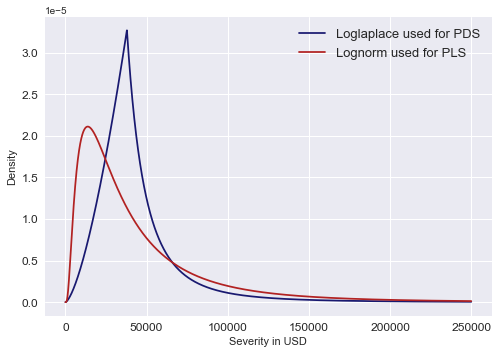

In [7]:
# Raw claim severity by type:
x = np.linspace(0, 250000, 5000)

#making the pdf for this linespace:
sim_pds = ss.loglaplace.pdf(x, *BF.iloc[1,0])
sim_pls = ss.lognorm.pdf(x, *BF.iloc[1,1])

#comparison
plt.plot(x, sim_pds, label="Loglaplace used for PDS", color="midnightblue")
plt.plot(x, sim_pls, label="Lognorm used for PLS", color="firebrick")
plt.xlabel("Severity in USD")
plt.ylabel("Density")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=13)
plt.savefig('sim_rsev_type.png', dpi=300, bbox_inches='tight')

Now we will do the same for the raw claims by site:

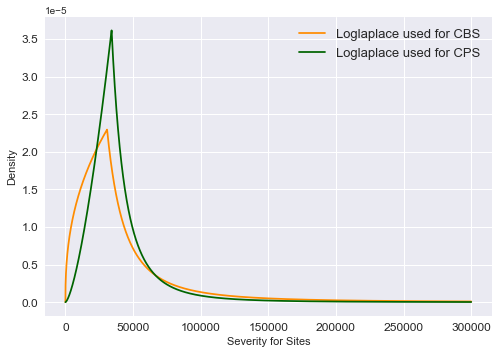

In [8]:
# Raw claim severity by site:
x = np.linspace(0, 300000, 5000)

#making the pdf for this linespace:
sim_cbs = ss.loglaplace.pdf(x, *BF.iloc[1,2])
sim_cps = ss.loglaplace.pdf(x, *BF.iloc[1,3])

#comparison
plt.plot(x, sim_cbs, label="Loglaplace used for CBS", color="darkorange")
plt.plot(x, sim_cps, label="Loglaplace used for CPS", color="darkgreen")
plt.xlabel("Severity for Sites")
plt.ylabel("Density")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=13)
plt.savefig('sim_rsev_site.png', dpi=300, bbox_inches='tight')

### Part 2. Modelling the raw claim counts with discrete distributions 

The code for the discrete optimizer was developed by Matt Haberland and [posted here](https://github.com/scipy/scipy/issues/11948).

In [3]:
############################DISCRETE OPTIMIZER 
from scipy.optimize import brute, differential_evolution
import warnings

def func(free_params, *args):
    dist, x = args
    ll = -np.log(dist.pmf(x, *free_params)).sum()
    if np.isnan(ll):  
        ll = np.inf   
    return ll

def fit_discrete(dist, x, bounds, optimizer=brute):
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore")  
        return optimizer(func, bounds, args=(dist, x))

#### 1. THE $\chi^2$ LOOP WITH DISCRETE DISTRIBUTIONS FOR PDX 

In this case we will only perform the loop for the $\chi^2$ test. The bounds for the brute force optimizer were set at 0 and 10,000. The code chunk below is meant to illustrate how this loop works for only one variable:

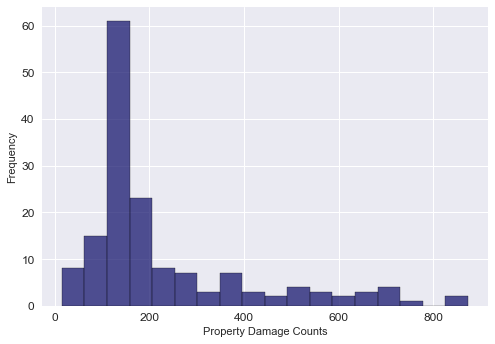

In [39]:
#making a histogram for the property damage counts:
bins = list(np.histogram_bin_edges(df['pdx'], bins='auto'))
sns.histplot(df['pdx'], kde=False, bins=bins, color="midnightblue")
plt.ylabel('Frequency')
plt.xlabel('Property Damage Counts')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('pdx_hist.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
#DEBUGGED VERSION OF LOOP 
#setting up the quantiles to build the bins:
qs = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1]

#Distributions 
list_of_dists = ['binom', 'nbinom', 'poisson', 'boltzmann', 'planck', 'geom', 'logser', 'randint']

X1 = df['pdx'].to_numpy()
results = []
for i in tqdm(list_of_dists):
    bounds = [(0, 10000), (0, 1)]
    dist = getattr(ss, i)
    param = list(fit_discrete(dist, X1, bounds))
    pq1 = list(dist.ppf(qs, *param))
    pq1.insert(0,0)
    pq1 = list(pq1[:-1])
    pq1.append(20000)
    hist, bin_edges = np.histogram(X1, bins=pq1)
    n = len(X1)
    freq1 = list(hist)
    B = list(bin_edges)
    fexp1 = []
    for k in range(1,21):
        f = ((dist.cdf(B[k], *param) - dist.cdf(B[k-1], *param))*n)
        fexp1.append(f)
    a = ss.chisquare(f_obs=freq1, f_exp=fexp1, ddof=len(param))
    results.append((i,param, a[0],a[1]))
    
    
dfr = pd.DataFrame(results, columns =['Distribution', 'MLE Parameters', 'Chi-square stat', 'P-value'])
dfr.sort_values(by=['P-value'], ascending=False, inplace=True)
dfr

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.73it/s]


,Distribution,MLE Parameters,Chi-square stat,P-value
1,nbinom,"[2.139883173181995, 0.00922814420430195]",110.516998,9.645497e-16
0,binom,"[323219.66863245284, 0.0007093178893901961]",1344.435961,1.328733e-275
4,planck,"[0.00025, 0.0]",1416.909300,3.604265e-291
5,geom,"[0.00025, 0.0]",1429.738975,6.312580e-294
2,poisson,"[526.3157894736842, 0.0]",2105.364621,0.000000e+00
3,boltzmann,"[0.0, 0.0]",NaN,NaN
6,logser,"[0.0, 0.0]",NaN,NaN
7,randint,"[0.0, 0.0]",NaN,NaN


Looking at the results, none of the discrete distributions are good fits according to the test. However, the Negative Binomial has a considerably lower stat than the others. Below, we will plot random simulations from some of these distributions to visualize them with the original claim fequencies:

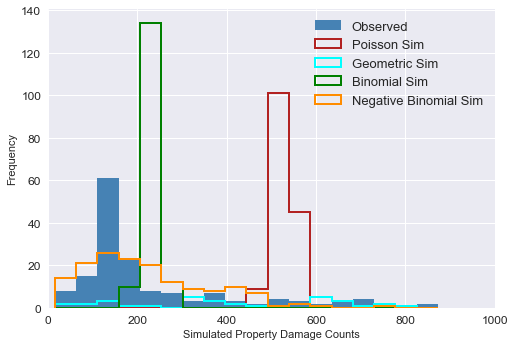

In [33]:
#generating simulated series 
data_nbinom = ss.nbinom.rvs(*dfr.iloc[0,1], size=len(X1))
data_binom= ss.binom.rvs(323220, 0.0007093178893901961, size=len(X1))
data_geom = ss.geom.rvs(*dfr.iloc[2,1], size=len(X1))
data_poisson = ss.poisson.rvs(*dfr.iloc[4,1], size=len(X1))


plt.hist(X1, bins=bins, alpha=1, label="Observed", color="midnightblue")
plt.hist(data_poisson, bins=bins, alpha=1, label="Poisson Sim", color="firebrick", histtype='step', linewidth=2)
plt.hist(data_geom, bins=bins, alpha=1, label="Geometric Sim", color="cyan", histtype='step', linewidth=2)
plt.hist(data_binom, bins=bins, alpha=1, label="Binomial Sim", color="green", histtype='step', linewidth=2)
plt.hist(data_nbinom, bins=bins, alpha=1, label="Negative Binomial Sim", color="darkorange", histtype='step', linewidth=2)
plt.ylabel("Frequency")
plt.xlabel("Simulated Property Damage Counts")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=13)
plt.xlim([0,1000])
plt.savefig('pdx_comparison.png', dpi=300, bbox_inches='tight')

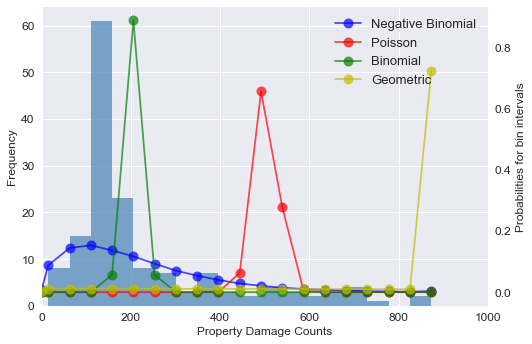

In [27]:
b2 = list(bins)
b2.insert(0,0)
b2.append(10000)
fnb = []
fp = []
fb = []
fg = []
for k in range(1,len(b2)):
    f = (ss.nbinom.cdf(b2[k], *dfr.iloc[0,1]) - ss.nbinom.cdf(b2[k-1], *dfr.iloc[0,1]))
    f2 = (ss.poisson.cdf(b2[k], *dfr.iloc[4,1]) - ss.poisson.cdf(b2[k-1], *dfr.iloc[4,1]))
    f3 = (ss.binom.cdf(b2[k], 323220, 0.0007093178893901961) - ss.binom.cdf(b2[k-1], 323220, 0.0007093178893901961))
    f4 = (ss.geom.cdf(b2[k], *dfr.iloc[2,1]) - ss.geom.cdf(b2[k-1], *dfr.iloc[2,1]))
    fnb.append(f)
    fp.append(f2)
    fb.append(f3)
    fg.append(f4)
    
fig, ax1 = plt.subplots()
ax1.hist(X1, bins=bins, label="Observed", color="steelblue", alpha=0.7)
ax1.set_xlabel('Property Damage Counts', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Probabilities for bin intervals', fontsize=12)  # we already handled the x-label with ax1
ax2.plot(b2[:20], fnb[0:],'b-o', ms=10, label="Negative Binomial", alpha=0.7)
ax2.plot(b2[:20], fp[0:],'r-o', ms=10, label="Poisson", alpha=0.7)
ax2.plot(b2[:20], fb[0:],'g-o', ms=10, label="Binomial", alpha=0.7)
ax2.plot(b2[:20], fg[0:],'y-o', ms=10, label="Geometric", alpha=0.7)

plt.xlim([0,1000])
plt.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax2.grid(False)
plt.savefig('pdx_comparison_v2.png', dpi=300, bbox_inches='tight')

#### 2. THE $\chi^2$ LOOP WITH DISCRETE DISTRIBUTIONS FOR ALL COUNT SERIES 

Now we can apply it to all the count series in the raw dataset:

In [30]:
qs = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1]

#Distributions 
list_of_dists = ['binom', 'nbinom', 'poisson', 'boltzmann', 'planck', 'geom', 'logser', 'randint']


dfs = df[['pdx', 'plx', 'cbx', 'cpx']]


# retrieving the names of each asset from the dataset:
names = list(dfs.columns)

bestfits = {}
for na in tqdm(names):
    results = []
    for i in list_of_dists:
        bounds = [(0, 10000), (0, 1)]
        dist = getattr(ss, i)
        param = list(fit_discrete(dist, dfs[na], bounds))
        pq1 = list(dist.ppf(qs, *param))
        pq1.insert(0,0)
        pq1 = list(pq1[:-1])
        pq1.append(20000)
        hist, bin_edges = np.histogram(dfs[na].to_numpy(), bins=pq1)
        n = len(dfs[na])
        freq1 = list(hist)
        B = list(bin_edges)
        fexp1 = []
        for k in range(1,21):
            f = ((dist.cdf(B[k], *param) - dist.cdf(B[k-1], *param))*n)
            fexp1.append(f)
        a = ss.chisquare(f_obs=freq1, f_exp=fexp1, ddof=len(param))
        results.append((i,param, a[0],a[1]))
        dfr = pd.DataFrame(results, columns =['Best fit dist', 'MLE params', 'Chi-square stat', 'p-value'])
        dfr.sort_values(by=['p-value'], ascending=False, inplace=True)
    bestfits[na] = dfr.iloc[0]
    

BF = pd.DataFrame.from_dict(bestfits)
BF.columns = names
BF

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.55s/it]


,pdx,plx,cbx,cpx
Best fit dist,nbinom,nbinom,nbinom,nbinom
MLE params,"[2.139883173181995, 0.00922814420430195]","[1.7579089737306162, 0.006834721956499432]","[1.3966908444521602, 0.003585989036498995]","[4.676652646199874, 0.03724209891451029]"
Chi-square stat,110.517,97.0723,147.492,47.8349
p-value,9.6455e-16,3.09301e-13,7.57287e-23,9.10049e-05


Now we can do a simulation plot for the raw claim counts by type:

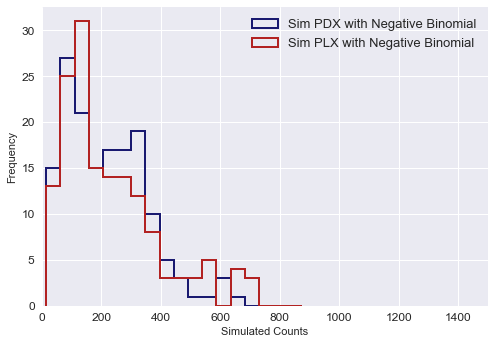

In [41]:
#SIMULATION PLOT FOR CLAIM COUNTS: 
sim_pdx = ss.nbinom.rvs(*BF.iloc[1,0], size=len(dfs))
sim_plx = ss.nbinom.rvs(*BF.iloc[1,1], size=len(dfs))
plt.hist(sim_pdx, bins=bins, alpha=1, label="Sim PDX with Negative Binomial", color="midnightblue", histtype='step', linewidth=2)
plt.hist(sim_plx, bins=bins, alpha=1, label="Sim PLX with Negative Binomial", color="firebrick", histtype='step', linewidth=2)
plt.ylabel("Frequency")
plt.xlabel("Simulated Counts")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=13)
plt.xlim([0,1500])
plt.savefig('sim_rcounts_type.png', dpi=300, bbox_inches='tight')

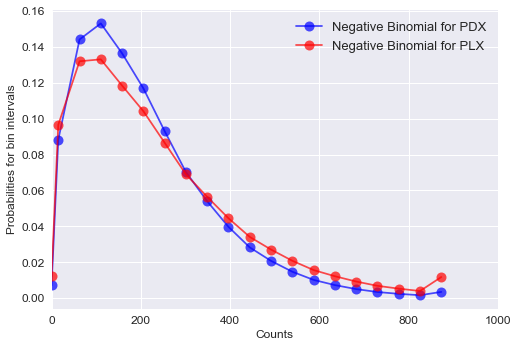

In [32]:
b2 = list(bins)
b2.insert(0,0)
b2.append(20000)
fp1 = []
fp2 = []
for k in range(1,len(b2)):
    f = (ss.nbinom.cdf(b2[k], *BF.iloc[1,0]) - ss.nbinom.cdf(b2[k-1], *BF.iloc[1,0]))
    f2 = (ss.nbinom.cdf(b2[k], *BF.iloc[1,1]) - ss.nbinom.cdf(b2[k-1], *BF.iloc[1,1]))
    fp1.append(f)
    fp2.append(f2)
    
plt.xlabel('Counts', fontsize=12)
plt.ylabel('Probabilities for bin intervals', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(b2[:20], fp1[0:],'b-o', ms=10, label="Negative Binomial for PDX", alpha=0.7)
plt.plot(b2[:20], fp2[0:],'r-o', ms=10, label="Negative Binomial for PLX", alpha=0.7)

plt.xlim([0,1000])
plt.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax2.grid(False)
plt.savefig('type_comparison_v2.png', dpi=300, bbox_inches='tight')

Next, we will do a similar plot for the raw claim counts by site:

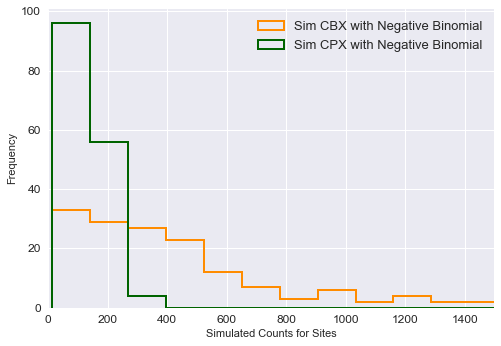

In [42]:
#SIMULATION PLOT FOR CLAIM COUNTS: 
bins2 = list(np.histogram_bin_edges(df['cbx'], bins='auto'))

sim_cbx = ss.nbinom.rvs(*BF.iloc[1,2], size=len(dfs))
sim_cpx = ss.nbinom.rvs(*BF.iloc[1,3], size=len(dfs))
plt.hist(sim_cbx, bins=bins2, alpha=1, label="Sim CBX with Negative Binomial", color="darkorange", histtype='step', linewidth=2)
plt.hist(sim_cpx, bins=bins2, alpha=1, label="Sim CPX with Negative Binomial", color="darkgreen", histtype='step', linewidth=2)
plt.ylabel("Frequency")
plt.xlabel("Simulated Counts for Sites")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=13)
plt.xlim([0,1500])
plt.savefig('sim_rcounts_site.png', dpi=300, bbox_inches='tight')

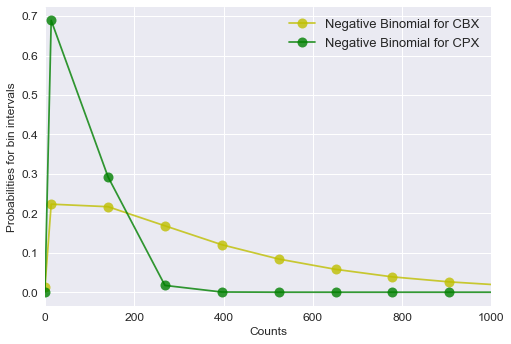

In [38]:
bins2 = list(np.histogram_bin_edges(df['cbx'], bins='auto'))
b2 = list(bins2)
b2.insert(0,0)
b2.append(20000)
fp1 = []
fp2 = []
for k in range(1,len(b2)):
    f = (ss.nbinom.cdf(b2[k], *BF.iloc[1,2]) - ss.nbinom.cdf(b2[k-1], *BF.iloc[1,2]))
    f2 = (ss.nbinom.cdf(b2[k], *BF.iloc[1,3]) - ss.nbinom.cdf(b2[k-1], *BF.iloc[1,3]))
    fp1.append(f)
    fp2.append(f2)
    
plt.xlabel('Counts', fontsize=12)
plt.ylabel('Probabilities for bin intervals', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(b2[:15], fp1[0:],'y-o', ms=10, label="Negative Binomial for CBX", alpha=0.8)
plt.plot(b2[:15], fp2[0:],'g-o', ms=10, label="Negative Binomial for CPX", alpha=0.8)

plt.xlim([0,1000])
plt.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax2.grid(False)
plt.savefig('site_comparison_v2.png', dpi=300, bbox_inches='tight')

### Part 3. Modelling the detrended claim severities

This final section will be dedicated to modelling the detrended claim severities 

In [51]:
df = pd.read_csv("C:/Users/r_jun/Documents/ISEG MSc Actuarial Science/Thesis/Python/FINAL/CH4/Detrended by Type/aggregated_detrended_series.csv")
df.describe()

,Unnamed: 0,pdx,pds,plx,pls,cbx,cbs,cpx,cps
count,156.000000,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02
mean,77.500000,3.753123e-14,1.770017e-11,-1.552263e-13,2.938367e-12,5.757218e-14,8.581899e-12,-3.666583e-15,2.775125e-12
std,45.177428,8.981529e+01,1.394064e+04,1.167014e+02,2.230552e+04,1.980951e+02,3.275734e+04,2.876242e+01,1.251592e+04
min,0.000000,-4.223615e+02,-4.634860e+04,-4.378416e+02,-7.900797e+04,-1.036661e+03,-1.651316e+05,-8.746980e+01,-2.681667e+04
25%,38.750000,-3.907830e+01,-6.181272e+03,-7.741136e+01,-1.125709e+04,-8.708965e+01,-1.401144e+04,-1.350966e+01,-8.766360e+03
50%,77.500000,1.889838e+00,8.814776e+02,-2.758647e+00,-2.496194e+03,-1.386099e+00,-2.069880e+03,2.265712e+00,1.125036e+02
75%,116.250000,3.550041e+01,5.587979e+03,7.064126e+01,1.019178e+04,8.913627e+01,1.233685e+04,1.582114e+01,6.153436e+03
max,155.000000,3.640041e+02,5.674145e+04,4.779544e+02,9.445369e+04,7.507874e+02,1.196577e+05,1.289910e+02,7.465435e+04


#### 1. Kolmogorov-Smirnov Loop for detrended severities 

In [52]:
import warnings
warnings.filterwarnings("ignore")


#Distributions 
list_of_dists = ['beta','burr','cauchy','chi','chi2','dgamma','dweibull','expon','exponnorm','exponweib','exponpow',
                 'frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','gamma','gengamma',
                 'gompertz','gumbel_r','gumbel_l','hypsecant','invgamma','invgauss','invweibull',
                 'johnsonsb','johnsonsu','laplace','logistic','loglaplace','lognorm',
                 'lomax','nct','norm','pareto','t','triang','truncexpon','truncnorm','tukeylambda',
                 'uniform','weibull_min','weibull_max']

dfs = df[['pds', 'pls', 'cbs', 'cps']]


# retrieving the names of each asset from the dataset:
names = list(dfs.columns)
# loop to find the best fit distribution according to Kolmogorov-Smirnov test:
bestfits = {}
for n in tqdm(names):
    results = []
    for i in list_of_dists:
        dist = getattr(ss, i)
        param = dist.fit(dfs[n])
        a = ss.kstest(dfs[n], i, args=param)
        results.append((i,param, a[0],a[1]))
        dfr = pd.DataFrame(results, columns =['Best fit dist', 'MLE params', 'KS stat', 'p-value'])
        dfr.sort_values(by=['p-value'], ascending=False, inplace=True)
    bestfits[n] = dfr.iloc[0]
# storing the best fits in a dataframe:    
BF1 = pd.DataFrame.from_dict(bestfits)
BF1

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.70s/it]


,pds,pls,cbs,cps
Best fit dist,dgamma,johnsonsu,johnsonsu,t
MLE params,"(1.1047286880232725, 1.727943970661069e-11, 87...","(-0.41099087995516004, 1.0232315395669909, -80...","(-0.2971611263763444, 0.955458600949966, -7354...","(5.883880871731515, -704.7655839511219, 9753.3..."
KS stat,0.0443286,0.0422713,0.0447596,0.0502398
p-value,0.905535,0.931986,0.899417,0.806978


#### 2. $\chi^2$ Loop for detrended severities 

In [27]:
import warnings
warnings.filterwarnings("ignore")
#setting up the quantiles to build the bins:
qs = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1]

#Distributions 
list_of_dists = ['beta','cauchy','chi','chi2','dgamma','dweibull','expon','exponnorm','exponpow',
                 'genlogistic','gennorm','genexpon','gamma',
                 'gompertz','gumbel_r','gumbel_l','hypsecant',
                 'johnsonsb','johnsonsu','laplace','logistic','nct','norm',
                 't','triang','truncexpon','truncnorm','tukeylambda',
                 'uniform']

dfs = df[['pds', 'pls', 'cbs', 'cps']]


# retrieving the names of each asset from the dataset:
names = list(dfs.columns)

bestfits = {}
for na in tqdm(names):
    results = []
    for i in list_of_dists:
        dist = getattr(ss, i)
        param = list(dist.fit(dfs[na]))
        pq1 = list(dist.ppf(qs, *param))
        pq1.insert(0,-450000)
        pq1 = list(pq1[:-1])
        pq1.append(450000)
        hist, bin_edges = np.histogram(dfs[na].to_numpy(), bins=pq1)
        n = len(dfs[na])
        freq1 = list(hist)
        B = list(bin_edges)
        fexp1 = []
        for k in range(1,21):
            f = ((dist.cdf(B[k], *param) - dist.cdf(B[k-1], *param))*n)
            fexp1.append(f)
        a = ss.chisquare(f_obs=freq1, f_exp=fexp1, ddof=len(param))
        results.append((i,param, a[0],a[1]))
        dfr = pd.DataFrame(results, columns =['Best fit dist', 'MLE params', 'Chi-square stat', 'p-value'])
        dfr.sort_values(by=['p-value'], ascending=False, inplace=True)
    bestfits[na] = dfr.iloc[0]
    

BF = pd.DataFrame.from_dict(bestfits)
BF.columns = names
BF

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:33<00:00,  8.26s/it]


,pds,pls,cbs,cps
Best fit dist,johnsonsu,nct,t,dgamma
MLE params,"[0.10969438260416041, 1.0468429582363932, 1211...","[2.36318439656056, 0.6603089079082696, -11186....","[2.216470896932953, -1857.8884396683388, 15819...","[1.4625195008441993, 2.1392887943420333e-12, 6..."
Chi-square stat,13.4872,17.1078,16.8236,16.8205
p-value,0.564722,0.312464,0.397098,0.397303


Now we can do a plot to contrast the best fit distributions for the detrended claim severities by type:

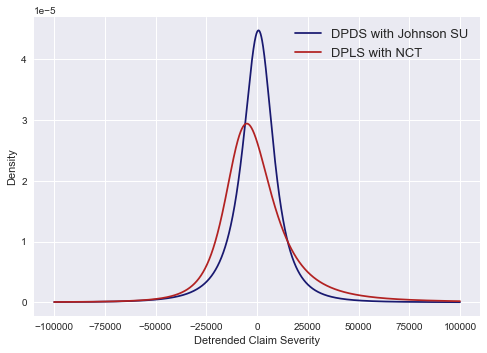

In [20]:
#detrended severity distribution:
x = np.linspace(-100000, 100000, 5000)

#making the pdf for this linespace:
sim_pds = ss.johnsonsu.pdf(x, *BF.iloc[1,0])
sim_pls = ss.nct.pdf(x, *BF.iloc[1,1])

#comparison
plt.plot(x, sim_pds, label="DPDS with Johnson SU", color="midnightblue")
plt.plot(x, sim_pls, label="DPLS with NCT", color="firebrick")
plt.xlabel("Detrended Claim Severity")
plt.ylabel("Density")
plt.legend(loc='upper right', fontsize=13)
plt.savefig('detrended_severities_type.png', dpi=300, bbox_inches='tight')

Next we will plot the detrended claim severities by site:

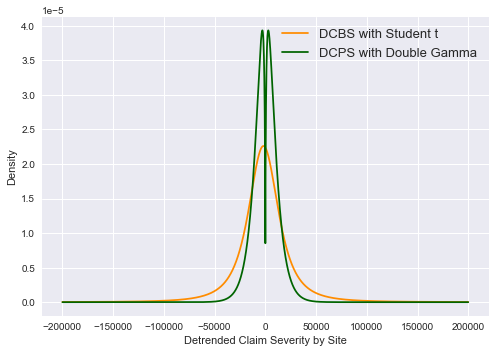

In [22]:
x = np.linspace(-200000, 200000, 5000)

#making the pdf for this linespace:
sim_dcbs = ss.t.pdf(x, *BF.iloc[1,2])
sim_dcps = ss.dgamma.pdf(x, *BF.iloc[1,3])

#comparison
plt.plot(x, sim_dcbs, label="DCBS with Student t", color="darkorange")
plt.plot(x, sim_dcps, label="DCPS with Double Gamma", color="darkgreen")
plt.xlabel("Detrended Claim Severity by Site")
plt.ylabel("Density")
plt.legend(loc='upper right', fontsize=13)
plt.savefig('detrended_severities_site.png', dpi=300, bbox_inches='tight')

### Part 4. Modelling the detrended claim counts

#### 1. Kolmogorov-Smirnov Loop for detrended counts 

In [29]:
import warnings
warnings.filterwarnings("ignore")

#Distributions 
list_of_dists = ['beta','burr','cauchy','chi','chi2','dgamma','dweibull','expon','exponnorm','exponweib','exponpow',
                 'frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','gamma','gengamma',
                 'gompertz','gumbel_r','gumbel_l','hypsecant','invgamma','invgauss','invweibull',
                 'johnsonsb','johnsonsu','laplace','logistic','loglaplace','lognorm',
                 'lomax','nct','norm','pareto','t','triang','truncexpon','truncnorm','tukeylambda',
                 'uniform','weibull_min','weibull_max']

dfs = df[['pdx', 'plx', 'cbx', 'cpx']]


# retrieving the names of each asset from the dataset:
names = list(dfs.columns)
# loop to find the best fit distribution according to Kolmogorov-Smirnov test:
bestfits = {}
for n in tqdm(names):
    results = []
    for i in list_of_dists:
        dist = getattr(ss, i)
        param = dist.fit(dfs[n])
        a = ss.kstest(dfs[n], i, args=param)
        results.append((i,param, a[0],a[1]))
        dfr = pd.DataFrame(results, columns =['Best fit dist', 'MLE params', 'KS stat', 'p-value'])
        dfr.sort_values(by=['p-value'], ascending=False, inplace=True)
    bestfits[n] = dfr.iloc[0]
# storing the best fits in a dataframe:    
BF1 = pd.DataFrame.from_dict(bestfits)
BF1

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.94s/it]


,pdx,plx,cbx,cpx
Best fit dist,tukeylambda,nct,nct,nct
MLE params,"(-0.31003069053412946, -7.920319596283174e-14,...","(4.960538915142913, 0.15778378306733729, -16.6...","(2.464513290692358, 0.011834974924177188, 0.71...","(3.8931146739405342, -0.5140487046086466, 12.8..."
KS stat,0.0414401,0.044712,0.0546879,0.0386527
p-value,0.941333,0.900102,0.718115,0.966886


#### 2. $\chi^2$ Loop for detrended counts

In [30]:
import warnings
warnings.filterwarnings("ignore")
#setting up the quantiles to build the bins:
qs = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1]

#Distributions 
list_of_dists = ['beta','cauchy','chi','chi2','dgamma','dweibull','exponnorm','exponpow',
                 'genlogistic','gennorm','expon','gamma',
                 'gompertz','gumbel_r','gumbel_l','hypsecant',
                 'johnsonsb','johnsonsu','laplace','logistic','nct','norm',
                 't','triang','truncexpon','truncnorm','tukeylambda',
                 'uniform']

dfs = df[['pdx', 'plx', 'cbx', 'cpx']]


# retrieving the names of each asset from the dataset:
names = list(dfs.columns)

bestfits = {}
for na in tqdm(names):
    results = []
    for i in list_of_dists:
        dist = getattr(ss, i)
        param = list(dist.fit(dfs[na]))
        pq1 = list(dist.ppf(qs, *param))
        pq1.insert(0,-2500)
        pq1 = list(pq1[:-1])
        pq1.append(2500)
        hist, bin_edges = np.histogram(dfs[na].to_numpy(), bins=pq1)
        n = len(dfs[na])
        freq1 = list(hist)
        B = list(bin_edges)
        fexp1 = []
        for k in range(1,21):
            f = ((dist.cdf(B[k], *param) - dist.cdf(B[k-1], *param))*n)
            fexp1.append(f)
        a = ss.chisquare(f_obs=freq1, f_exp=fexp1, ddof=len(param))
        results.append((i,param, a[0],a[1]))
        dfr = pd.DataFrame(results, columns =['Best fit dist', 'MLE params', 'Chi-square stat', 'p-value'])
        dfr.sort_values(by=['p-value'], ascending=False, inplace=True)
    bestfits[na] = dfr.iloc[0]
    

BF = pd.DataFrame.from_dict(bestfits)
BF.columns = names
BF

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.11s/it]


,pdx,plx,cbx,cpx
Best fit dist,t,nct,hypsecant,nct
MLE params,"[2.331890618597993, 0.6018809564047002, 45.406...","[4.960538915142913, 0.15778378306733729, -16.6...","[6.341120731910746e-14, 106.49317688046042]","[3.8931146739405342, -0.5140487046086466, 12.8..."
Chi-square stat,17.3287,19.641,32.2051,11.4359
p-value,0.364639,0.186141,0.0141886,0.721126


Plotting the best fit for the detrended claim counts by type:

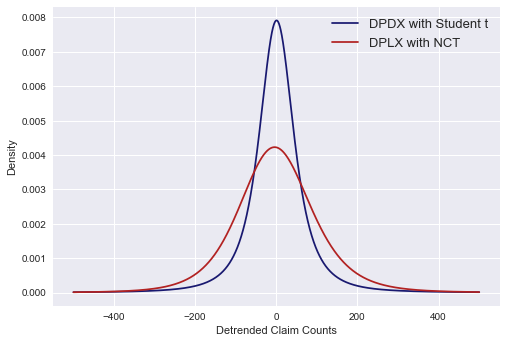

In [25]:
x = np.linspace(-500, 500, 5000)
#making the pdf for this linespace:
sim_dpdx = ss.t.pdf(x, *BF.iloc[1,0])
sim_dplx = ss.nct.pdf(x, *BF.iloc[1,1])

#comparison
plt.plot(x, sim_dpdx, label="DPDX with Student t", color="midnightblue")
plt.plot(x, sim_dplx, label="DPLX with NCT", color="firebrick")
plt.xlabel("Detrended Claim Counts")
plt.ylabel("Density")
plt.legend(loc='upper right', fontsize=13)
plt.savefig('detrended_counts_type.png', dpi=300, bbox_inches='tight')

Now we will do the same for the detrended claim counts by site:

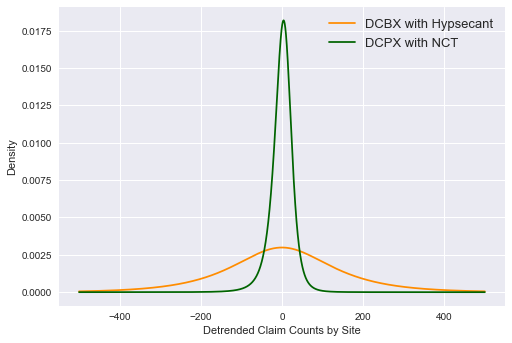

In [26]:
x = np.linspace(-500, 500, 5000)
#making the pdf for this linespace:
sim_dcbx = ss.hypsecant.pdf(x, *BF.iloc[1,2])
sim_dcpx = ss.nct.pdf(x, *BF.iloc[1,3])

#comparison
plt.plot(x, sim_dcbx, label="DCBX with Hypsecant", color="darkorange")
plt.plot(x, sim_dcpx, label="DCPX with NCT", color="darkgreen")
plt.xlabel("Detrended Claim Counts by Site")
plt.ylabel("Density")
plt.legend(loc='upper right', fontsize=13)
plt.savefig('detrended_counts_site.png', dpi=300, bbox_inches='tight')

### Part 5. Summary of best fit distributions


**I. RAW CLAIMS:**

pdx: ss.nbinom.cdf(x, 2.139883173181995, 0.00922814420430195)

pds: ss.loglaplace.cdf(x, 2.481704232311386, 0, 37891.93289315458)

plx: ss.nbinom.cdf(x, 1.7579089737306162, 0.006834721956499432)

pls: ss.lognorm.cdf(x, 0.9086819314521254, 0.0, 31402.11730335455)

cbx: ss.nbinom.cdf(x, 1.3966908444521602, 0.003585989036498995)

cbs: ss.loglaplace.cdf(x, 1.4149894458208154, 0, 30811.296859671424)

cpx: ss.nbinom.cdf(x, 4.676652646199874, 0.03724209891451029)

cps: ss.loglaplace.cdf(x, 2.470615641302211, 0, 34138.78552976878) 


**II. DETRENDED CLAIMS**

dpdx: ss.t.cdf(x, 2.331890618597993, 0.6018809564047002, 45.40661098100092)

dpds: ss.johnsonsu.cdf(x, 0.10969438260416041, 1.0468429582363932, 1211.5906573050079, 9305.032853814784)

dplx: ss.nct.cdf(x, 4.960538915142913, 0.15778378306733729, -16.622885444080023, 89.64896196042767)

dpls: ss.nct.cdf(x, 2.36318439656056, 0.6603089079082696, -11186.72718206899, 11886.154612459231)

dcbx: ss.hypsecant.cdf(x, 6.341120731910746e-14, 106.49317688046042)

dcbs: ss.t.cdf(x, 2.216470896932953, -1857.8884396683388, 15819.194302879092)

dcpx: ss.nct.cdf(x, 3.8931146739405342, -0.5140487046086466, 12.836944500934292, 20.316412489737665)

dcps: ss.dgamma.cdf(x, 2.216470896932953, -1857.8884396683388, 15819.194302879092) 
